In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
%matplotlib inline 

In [2]:
data = pd.read_csv("data/edelweiss_GGA1_pointData.txt", skiprows=1, \
                       names=['Erecoil_keV', 'yield'], \
                       delim_whitespace=True)

In [3]:
data.head(4)

,Erecoil_keV,yield
0,104.1920,1.150560
1,120.3400,1.018400
2,127.9750,0.988728
3,22.3243,0.400158


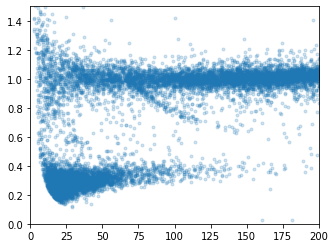

In [4]:
plt.plot(data['Erecoil_keV'], data['yield'], '.', alpha=0.2)
#plt.plot(path1_arr[:,0], path1_arr[:,1],'r--')
#minorLocatorX = MultipleLocator(10)
#minorLocatorY = MultipleLocator(0.1)
ax = plt.gca()
#ax.xaxis.set_minor_locator(minorLocatorX)
#ax.yaxis.set_minor_locator(minorLocatorY)
#plt.ylim(min(graph_points_GGA1[:,1]),max(graph_points_GGA1[:,1]))
#plt.yticks(list(set(graph_points_GGA1[:,1])))
#plt.tick_params(which="major", right=True, top=True, direction="in", length=12)
#plt.tick_params(which="minor", right=True, top=True, direction="in", length=10)
# see https://jdhao.github.io/2017/06/03/change-aspect-ratio-in-mpl/
ax.set_aspect(0.75*1.0/ax.get_data_ratio())
plt.xlim(0,200)
plt.ylim(0,1.5)
#plt.xticks(list(set(graph_points_GGA1[:,0])))
plt.show()

In [5]:
bin_edges_ER = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 200])
bin_edges_NR = np.array([0, 10, 20, 30, 40, 50, 75, 150])
labels_ER = np.arange(0,len(bin_edges_ER)-1, step=1)
print (bin_edges_ER, labels_ER)

[  0  20  40  60  80 100 120 140 160 200] [0 1 2 3 4 5 6 7 8]


In [6]:
data['binER'] = pd.cut(data['Erecoil_keV'], bins=bin_edges_ER) #, labels=labels_ER)
data['binNR'] = pd.cut(data['Erecoil_keV'], bins=bin_edges_NR)
data.head(15)
data.binNR.unique()

[(75.0, 150.0], (20.0, 30.0], (30.0, 40.0], (40.0, 50.0], NaN, (50.0, 75.0], (10.0, 20.0], (0.0, 10.0]]
Categories (7, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 75] < (75, 150]]

In [7]:
from lmfit.models import  GaussianModel
from lmfit import printfuncs

gmodel = GaussianModel()
params = gmodel.make_params()
gmodel.param_names

['sigma', 'center', 'amplitude', 'fwhm', 'height']

(0, 10]
Erecoil_keV    8.472975
yield          0.446997
dtype: float64


C:\Users\robamy\.conda\envs\nr_fano\lib\site-packages\lmfit\confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(sigma=0.9419752282282516) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\robamy\.conda\envs\nr_fano\lib\site-packages\lmfit\confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(center=3.0535800100192683) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\robamy\.conda\envs\nr_fano\lib\site-packages\lmfit\confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(amplitude=307.43280457367615) = 0.0 < max(sigmas).
  warn(errmsg)


{'sigma': 0.7849793568568764, 'center': 2.5446500083493904, 'amplitude': 256.1940038113968}
              99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 sigma    :  -0.49356  -0.49742  -0.49678   0.78498      +inf      +inf      +inf
 center   :  -2.11761  -2.09769  -2.05416   2.54465      +inf      +inf      +inf
 amplitude:-255.37744-255.18197-254.70851 256.19400      +inf      +inf      +inf
(10, 20]
Erecoil_keV    16.451962
yield           0.282067
dtype: float64
{'sigma': 0.06553560760425614, 'center': 0.266157818344784, 'amplitude': 14.521929414922008}
              99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 sigma    :  -0.00985  -0.00671  -0.00346   0.06554  +0.00385  +0.00834  +0.01386
 center   :  -0.00915  -0.00578  -0.00280   0.26616  +0.00276  +0.00561  +0.00869
 amplitude:  -1.83807  -1.23189  -0.62704  14.52193  +0.67764  +1.44435  +2.36044
(20, 30]
Erecoil_keV    24.550350
yield           0.272574
dtype: float64
{'sigma': 0.0

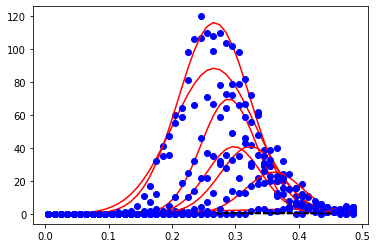

In [8]:
energy = []
center = []
sigma = []
width = []

for bin_name, bin_data in data.groupby('binNR'):
    print (bin_name)
    print (bin_data[bin_data['yield'] < 0.6].mean())
    
    
    min_yield = 0
    max_yield = 0.5
    binspace = 0.01
    hist_bins = np.arange(min_yield, max_yield, binspace)
    n, bins = np.histogram(bin_data['yield'], bins=hist_bins)
    lower = np.resize(bins, len(bins)-1)
    tmid = lower + 0.5*np.diff(bins)

    # guess the parameters, and then fit
    gmodel.guess(n, x=tmid)
    result = gmodel.fit(n, x=tmid, weights=np.sqrt(n))
    
    result.conf_interval()
    print(result.best_values)
    printfuncs.report_ci(result.ci_out)
    plt.plot(tmid, result.best_fit, 'r-')
    plt.plot(tmid, result.init_fit, 'k--')
    plt.plot(tmid, n,         'bo')
    
    energy.append(bin_data[bin_data['yield'] < 0.6]['Erecoil_keV'].mean())
    center.append(result.best_values['center'])
    sigma.append(np.abs(result.ci_out['center'][2][1]-result.best_values['center']))
    width.append(result.best_values['sigma'])
    
print (energy, center, sigma, width)

In [9]:
print (tabulate({"Energy (keV)": energy, "Center Yield": center, "1 Sigma": sigma, "Yield Width": width}, headers="keys", tablefmt="plain"))

  Energy (keV)    Center Yield     1 Sigma    Yield Width
       8.47298        2.54465   2.05416         0.784979
      16.452          0.266158  0.00279963      0.0655356
      24.5504         0.266692  0.00115917      0.0563158
      34.4388         0.289454  0.00134825      0.0434497
      44.7801         0.29754   0.00241049      0.0434861
      59.4559         0.323501  0.0019407       0.0469611
      98.6765         0.361059  0.00252753      0.0447333


In [10]:
filename = "data/edelweiss_avgYeild_GGA1.txt"

if True: 
    with open(filename, 'w') as file:
        file.write(tabulate({"Energy (keV)": energy, "Center Yield": center, "1 Sigma": sigma, "Yield Width": width}, headers="keys", tablefmt="plain"))

In [11]:
yield_data = pd.read_csv(filename, skiprows=1, \
                       names=['Erecoil_keV', 'yield', 'sigma_fit', 'sigma'], \
                       delim_whitespace=True)

In [12]:
yield_data.head(5)

,Erecoil_keV,yield,sigma_fit,sigma
0,8.47298,2.544650,2.054160,0.784979
1,16.45200,0.266158,0.002800,0.065536
2,24.55040,0.266692,0.001159,0.056316
3,34.43880,0.289454,0.001348,0.043450
4,44.78010,0.297540,0.002410,0.043486


(0, 0.5)

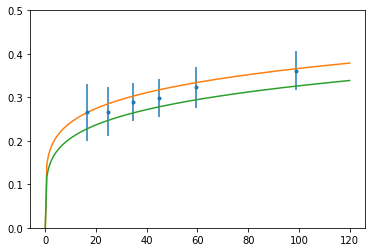

In [13]:
Erecoil_arr = np.linspace(0, 120, 200)

plt.errorbar(yield_data['Erecoil_keV'][1::], yield_data['yield'][1::], yerr=yield_data['sigma'][1::], fmt='o', markersize=3)
plt.plot(Erecoil_arr, 0.16*np.power(Erecoil_arr, 0.18))
plt.plot(Erecoil_arr, 0.13*np.power(Erecoil_arr, 0.2))
plt.ylim(0,0.5)